# <center>CS568:Deep Learning</center>  <center>Spring 2020</center> 

# Test 7

**Due **: Thursday, April 16, 2020 before **5.00 PM**

Implement a Neural Network for multiclass classification.
+ Code up a generic implementation.
+ Train it on the MNIST digits training data.
+ Report classification accuracy and confusion matrix on the testing data. **(20 marks)**




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download the MNIST dataset

In [5]:
from torch.utils import data
from torchvision import transforms
import torchvision
import torch
batch_size = 100
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='/data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='/data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

print("train_dataset", train_loader)
print("test_dataset", test_loader)

train_dataset <torch.utils.data.dataloader.DataLoader object at 0x7f8acab59a20>
test_dataset <torch.utils.data.dataloader.DataLoader object at 0x7f8acab3ee80>


Neural Network

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import torch.nn as nn
from torchsummary import summary
from time import time
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def plot_loss(loss,val_loss, len_layer, learning_rate):        
    plt.figure()
    fig = plt.gcf()
    plt.plot(loss, linewidth=3, label="train")
    plt.plot(val_loss, linewidth=3, label="val")
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.title('learning rate =%s, hidden layers=%s' % (learning_rate, len_layer-1))
    plt.grid()
    plt.legend()
    plt.show()
    fig.savefig('plot_loss.png')
        
    
def plot_gradients(net, len_layer):
    avg_l_g = []
    for idx, param in enumerate(net.parameters()):
        if idx % 2 == 0:
             weights_grad = param.grad 
             dim = weights_grad.shape[0]
             avg_g = []
             for d in range(dim):
                 abs_g = np.abs(weights_grad[d].numpy())           
                 avg_g.append(np.mean(abs_g))             
             temp = np.mean(avg_g)
             avg_l_g.append(temp)   
    layers = ['layer %s'%l for l in range(len_layer+1)]
    weights_grad_mag = avg_l_g
    fig = plt.gcf()
    plt.xticks(range(len(layers)), layers)
    plt.xlabel('layers')
    plt.ylabel('average gradients magnitude')
    plt.title('')
    plt.bar(range(len(weights_grad_mag)),weights_grad_mag, color='red', width=0.2) 
    plt.show() 
    fig.savefig('plot_gradients.png')
    

class NeuralNet(nn.Module):
    def __init__(self, size_list, activations):
        super(NeuralNet, self).__init__()
        layers = []
        for i in range(len(size_list) - 2):
            layers.append(nn.Linear(size_list[i],size_list[i+1]))
            if activations[i+1] == 'sigmoid':
                act = nn.Sigmoid()
            elif activations[i+1] =='tanh':
                act = nn.Tanh()
            elif activations[i+1] == 'relu':
                act = nn.ReLU()
            layers.append(act)
        layers.append(nn.Linear(size_list[-2], size_list[-1]))
        #because this is classification
        layers.append(nn.LogSoftmax(dim=1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = self.net(x)
        return x

def train(train_loader, learning_rate, num_epochs, layer_dim, activations):
    train_loss = []
    val_loss = []  
    time0 = time()

    len_layer = len(layer_dim) - 1
    
    net = NeuralNet(layer_dim, activations)    
    calculate_loss = nn.NLLLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
    print(net)

    
 
    
    total_parameters = sum(p.numel() for p in net.parameters())
    print("total number of parameters:", total_parameters)
    #summary(net, (784//2,128))
    
    
    for i in range(0, num_epochs):
        running_loss = 0
        for images, labels in train_loader:
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)

            # Forward pass
            outputs = net(images)
            loss = calculate_loss(outputs,labels)
            
            # Backprop and update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()                
            running_loss += loss.item()
        train_loss.append(loss)       
        print("Epoch {} - Training loss: {}".format(i, running_loss/len(train_loader)))
    
    print("\nTraining Time (in minutes) =",(time()-time0)/60)    
    plot_loss(train_loss,val_loss, len_layer, learning_rate)      
    plot_gradients(net, len_layer)
    
    checkpoint = {'model': NeuralNet(layer_dim, activations),
                  'state_dict': net.state_dict(),
                  'optimizer' : optimizer.state_dict()}
    torch.save(checkpoint, 'checkpoint.pth')

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    model.eval()
    return model
    
def test(test_loader):
    pred_labels = []
    true_labels = [] 
    net = load_checkpoint('checkpoint.pth')
    correct_count, all_count = 0, 0
    for images,labels in test_loader:
        for i in range(len(labels)):
            img = images[i].view(1, 784)
            with torch.no_grad():
                logps = net(img)
            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            pred_labels.append(pred_label)
            true_labels.append(true_label)
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

    print("Number Of Images Tested =", all_count)
    print("\nModel Accuracy =", 100*(correct_count/all_count))
    confusion_mat = confusion_matrix(true_labels, pred_labels)
    print("Confusion Matrx =",confusion_mat )
    print("Accuracy of each class")
    print(100*confusion_mat.diagonal()/confusion_mat.sum(1))    

Driver

NeuralNet(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=10, bias=True)
    (5): LogSoftmax()
  )
)
total number of parameters: 42310
Epoch 0 - Training loss: 0.608014450892806
Epoch 1 - Training loss: 0.24948035263766846
Epoch 2 - Training loss: 0.191724190308402
Epoch 3 - Training loss: 0.15456716002896428
Epoch 4 - Training loss: 0.12829783408281703
Epoch 5 - Training loss: 0.11153952650725842
Epoch 6 - Training loss: 0.09819567770231515
Epoch 7 - Training loss: 0.08702406350523234
Epoch 8 - Training loss: 0.07941572956042364
Epoch 9 - Training loss: 0.07163981922126064
Epoch 10 - Training loss: 0.06465317787447324
Epoch 11 - Training loss: 0.060729783490144955
Epoch 12 - Training loss: 0.05590223290647069
Epoch 13 - Training loss: 0.05147137723009412
Epoch 14 - Training loss: 0.047390851999322574

Training Time 

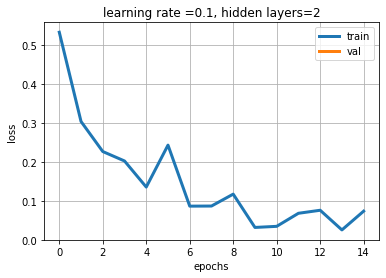

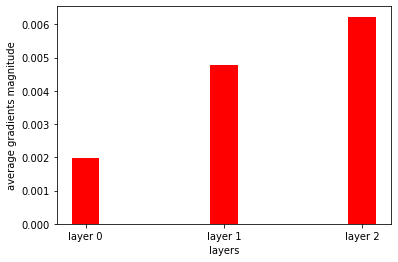

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type NeuralNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Number Of Images Tested = 10000

Model Accuracy = 97.42
Confusion Matrx = [[ 968    0    0    2    1    1    1    1    4    2]
 [   0 1119    2    2    1    1    1    1    8    0]
 [   7    2  997    7    6    0    1    4    8    0]
 [   0    0    2  995    0    3    0    5    2    3]
 [   0    0    3    0  972    0    3    1    1    2]
 [   2    1    1   13    5  852    2    1   12    3]
 [   3    3    2    1   10    2  931    0    6    0]
 [   2    5    8    3    2    0    0  996    3    9]
 [   2    0    5    8    5    2    3    2  945    2]
 [   2    2    0    7   16    3    1    9    2  967]]
Accuracy of each class
[98.7755102  98.59030837 96.60852713 98.51485149 98.98167006 95.51569507
 97.18162839 96.88715953 97.02258727 95.83746283]


In [7]:

# create l-dim network by just adding num of neurons in layer_dim
# first and last elements represent input and output layers dim
layer_dim = [784, 50,50, 10]

# add activation functions name here. 
# input layer activation function is None
activations = [None, 'relu','relu', 'identity']
assert len(layer_dim) ==  len(activations), "layer dim or activation is missing.."

# hyper parameters of neural network
learning_rate = 1e-1
num_epochs = 15
#mini_batch_size = 10

# train neural network 
train(train_loader, learning_rate, num_epochs,layer_dim, activations)


# test neural network 
test(test_loader)
